### Documenting Problem & Solution
---

**Problem:** Why can't we score *well* on data that's been loaded into the notebook?

**Solution**: It turns out the an `.after_batch` transform, `Normalize`, is added when the DL gets passed into the learner. We can get this one of two ways:
  - use the `test_dl = learn.dls.test_dl(..)` method which will attach the normalize transform.
  - explicilty add the normalize transfrom when building the dl.

Below we have a terse but complete overview of the problem. Bad confusion matrices represent methods that don't work well. Good confusion matrices represent methods that work like:
 - freshly trained model applying its own dls
 - dl built using test_dl() method
 - dl which explicitly adds the Normalize transform, and associated stats*
 
*: I dont't know if fully if fit-model-stats are required here, of if validation set can tune these params itself on-score.


In [2]:
from fastai2.vision.all import *

def piece_class_parse(fn): 
    fn = fn.split('_')[1]
    fn = fn.split('.')[0]
    return fn

path = Path('../../../rf-chess-data/cropped_v1/')

In [3]:
pieces = ImageDataLoaders.from_name_func(
                path, 
                get_image_files(path),
                valid_pct=0.2, 
                seed=42,
                label_func=piece_class_parse, 
                item_tfms=RandomResizedCrop(128, min_scale=0.5),
                batch_tfms=aug_transforms(),
                )

In [4]:
learn = cnn_learner(pieces, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.538157,0.222801,0.047038,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.320451,0.133744,0.022648,00:04
1,0.248465,0.140892,0.024390,00:04
2,0.189365,0.088763,0.010453,00:04
3,0.150542,0.089899,0.010453,00:04


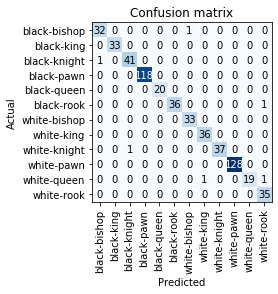

In [5]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Good: arg `dl` allows scoring on another dataset, not connected to `learn`
In this case we use the same dataset, `pieces`, specifically the validation set via `pieces.valid`. But this shows `ClassificationInterpretation` works the way we want it to.

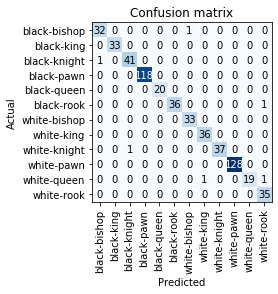

In [6]:
interp2 = ClassificationInterpretation.from_learner(
                                learn=learn, 
                                dl=pieces.valid) 

interp2.plot_confusion_matrix()

##### Load the same dataset, in the exact same way, to a different variable, `pieces2`

In [7]:
pieces2 = ImageDataLoaders.from_name_func(
                path, 
                get_image_files(path),
                valid_pct=0.2, 
                seed=42,
                label_func=piece_class_parse, 
                item_tfms=RandomResizedCrop(128, min_scale=0.5),
                batch_tfms=aug_transforms(),
                )

### Bad: now the model is not very predictive
when we score on `pieces2.valid`

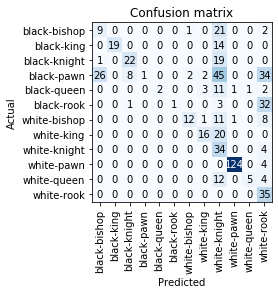

In [8]:
interp3 = ClassificationInterpretation.from_learner(
                                learn=learn, 
                                dl=pieces2.valid) 

interp3.plot_confusion_matrix()

##### Sanity Checks

In [9]:
pieces2.valid.items == pieces.valid.items

True

### Fix it - use `test_dl` method

In [10]:
same_items = get_image_files(path)
pieces3 = learn.dls.test_dl(same_items, bs=64, with_labels=True)

In [11]:
pieces3

In [12]:
interp4 = ClassificationInterpretation.from_learner(learn,
                                                   dl=pieces3)

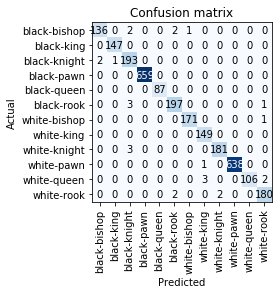

In [13]:
interp4.plot_confusion_matrix()

### Break + Fix it again - need to set Normalization in after_item transform

In [14]:
pieces4 = ImageDataLoaders.from_name_func(
                path, 
                get_image_files(path),
                valid_pct=0.2, 
                seed=42,
                label_func=piece_class_parse, 
                item_tfms=RandomResizedCrop(128, min_scale=0.5),
                batch_tfms=aug_transforms(),
                )

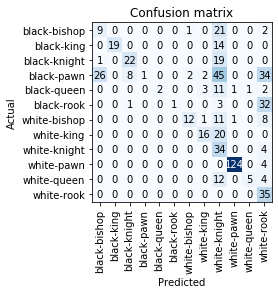

In [15]:
# not setting normalization
interp6 = ClassificationInterpretation.from_learner(learn,
                                                   dl=pieces4.valid)
interp6.plot_confusion_matrix()

##### so `pieces3` which has been passed thru `learn` has the Normalize transform, but `pieces4`, which is freshly built does not have it

In [16]:
pieces3.after_batch

Pipeline: IntToFloatTensor -> AffineCoordTfm -> LightingTfm -> Normalize

In [17]:
pieces4.valid.after_batch

Pipeline: IntToFloatTensor -> AffineCoordTfm -> LightingTfm

In [18]:
fit_norm = pieces3.after_batch[3]

##### we need to extract the Normalize parameters from the training model

In [19]:
fit_norm.mean, fit_norm.std, fit_norm.axes

(tensor([[[[0.4850]],
 
          [[0.4560]],
 
          [[0.4060]]]], device='cuda:0'),
 tensor([[[[0.2290]],
 
          [[0.2240]],
 
          [[0.2250]]]], device='cuda:0'),
 (0, 2, 3))

In [107]:
pieces4.after_batch.add(Normalize(
                            mean=fit_norm.mean, 
                            std=fit_norm.std, 
                            axes=fit_norm.axes)
                       )

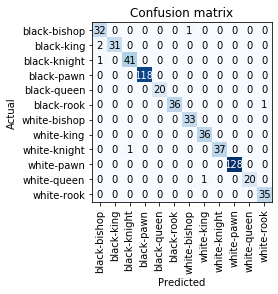

In [108]:
interp7 = ClassificationInterpretation.from_learner(learn,
                                                   dl=pieces4.valid)
interp7.plot_confusion_matrix()

##### Supplementary materials

In [35]:
old_path = learn.path
learn.path = Path('../')
learn.model_dir = 'models'
learn.save('demo-model-1')   # saves a 3x larger pth
learn.export('models/demo-model-1.pkl')   # saves a pickle
learn.path = old_path

In [36]:
!ls ../models -sh

total 398M
 52M bing-clean-1.pkl   48M chess1.pkl	      135M demo-model-1.pth
 52M bing-clean-2.pkl   57M demo-model-1.pkl   57M standard-piece-2.pkl


In [79]:
ab0 = learn.dls.after_batch[0]
ab1 = learn.dls.after_batch[1]
ab2 = learn.dls.after_batch[2]
ab3 = learn.dls.after_batch[3]

In [80]:
ab3.mean, ab3.std, ab3.axes

(tensor([[[[0.4850]],
 
          [[0.4560]],
 
          [[0.4060]]]], device='cuda:0'),
 tensor([[[[0.2290]],
 
          [[0.2240]],
 
          [[0.2250]]]], device='cuda:0'),
 (0, 2, 3))

In [91]:
pieces3.one_batch()[0].sum()

TensorImage(-648758.1250, device='cuda:0')

In [96]:
pieces2.valid